In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy scikit-learn
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install opencv-python
!pip install matplotlib
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.5 MB/s eta 0:00:00


In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [10]:
# === Load Patients ===
fa_patients_path = "/home/snu/Downloads/NIFD_Patients_FA_Histogram_Feature.npy"
Patients_FA_array = np.load(fa_patients_path, allow_pickle=True)

# === Load Controls ===
fa_controls_path = "/home/snu/Downloads/NIFD_Control_FA_Histogram_Feature.npy"
Controls_FA_array = np.load(fa_controls_path, allow_pickle=True)

print("Patients Shape:", Patients_FA_array.shape)
print("Controls Shape:", Controls_FA_array.shape)

# === Combine features and labels ===
X = np.vstack([Controls_FA_array, Patients_FA_array])
y = np.hstack([
    np.zeros(Controls_FA_array.shape[0], dtype=np.int64),  # 0 = Control
    np.ones(Patients_FA_array.shape[0], dtype=np.int64)    # 1 = Patient
])

# Shuffle
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

Patients Shape: (98, 180)
Controls Shape: (48, 180)


In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
# Stratified split
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.3, random_state=42)

In [13]:
# Storage for metrics
accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

In [14]:
all_y_true = []
all_y_proba = []
all_fpr = []
all_tpr = []
all_auc = []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(loss)
    all_y_true.extend(y_test)
    all_y_proba.extend(y_pred_proba)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_score)

    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Loss: {loss:.4f} | AUC: {auc_score:.4f}")

# Final average results
print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")


Training fold 1
Accuracy: 0.7500 | Precision: 0.7714 | Recall: 0.9000 | F1: 0.8308 | Loss: 0.5279 | AUC: 0.7571

Training fold 2
Accuracy: 0.7955 | Precision: 0.8000 | Recall: 0.9333 | F1: 0.8615 | Loss: 0.4750 | AUC: 0.9286

Training fold 3
Accuracy: 0.7273 | Precision: 0.8000 | Recall: 0.8000 | F1: 0.8000 | Loss: 0.5552 | AUC: 0.7310

Training fold 4
Accuracy: 0.7273 | Precision: 0.7500 | Recall: 0.9000 | F1: 0.8182 | Loss: 0.5591 | AUC: 0.7381

Training fold 5
Accuracy: 0.7045 | Precision: 0.7742 | Recall: 0.8000 | F1: 0.7869 | Loss: 0.4896 | AUC: 0.7929

Training fold 6
Accuracy: 0.7045 | Precision: 0.7576 | Recall: 0.8333 | F1: 0.7937 | Loss: 0.5162 | AUC: 0.7929

Training fold 7
Accuracy: 0.7727 | Precision: 0.7941 | Recall: 0.9000 | F1: 0.8438 | Loss: 0.4742 | AUC: 0.8357

Training fold 8
Accuracy: 0.6818 | Precision: 0.7667 | Recall: 0.7667 | F1: 0.7667 | Loss: 0.5116 | AUC: 0.7833

Training fold 9
Accuracy: 0.7955 | Precision: 0.8182 | Recall: 0.9000 | F1: 0.8571 | Loss: 0.49

In [ ]:
all_y_true = []
all_y_proba = []
all_fpr = []
all_tpr = []
all_auc = []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(loss)
    all_y_true.extend(y_test)
    all_y_proba.extend(y_pred_proba)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_score)

    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Loss: {loss:.4f} | AUC: {auc_score:.4f}")

# Final average results
print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")


Training fold 1
Accuracy: 0.6667 | Precision: 0.7273 | Recall: 0.8000 | F1: 0.7619 | Loss: 0.5884 | AUC: 0.7000

Training fold 2
Accuracy: 0.8000 | Precision: 0.8889 | Recall: 0.8000 | F1: 0.8421 | Loss: 0.5610 | AUC: 0.7400

Training fold 3
Accuracy: 0.8000 | Precision: 0.8889 | Recall: 0.8000 | F1: 0.8421 | Loss: 0.3862 | AUC: 0.9400

Training fold 4
Accuracy: 0.8000 | Precision: 0.8889 | Recall: 0.8000 | F1: 0.8421 | Loss: 0.4952 | AUC: 0.8400

Training fold 5
Accuracy: 0.8000 | Precision: 0.8889 | Recall: 0.8000 | F1: 0.8421 | Loss: 0.4903 | AUC: 0.8400

Training fold 6
Accuracy: 0.6000 | Precision: 0.6667 | Recall: 0.8000 | F1: 0.7273 | Loss: 0.6265 | AUC: 0.6800

Training fold 7
Accuracy: 0.6667 | Precision: 0.7273 | Recall: 0.8000 | F1: 0.7619 | Loss: 0.5962 | AUC: 0.6800

Training fold 8
Accuracy: 0.8667 | Precision: 0.8333 | Recall: 1.0000 | F1: 0.9091 | Loss: 0.4236 | AUC: 0.9400

Training fold 9
Accuracy: 0.6000 | Precision: 0.7000 | Recall: 0.7000 | F1: 0.7000 | Loss: 0.61

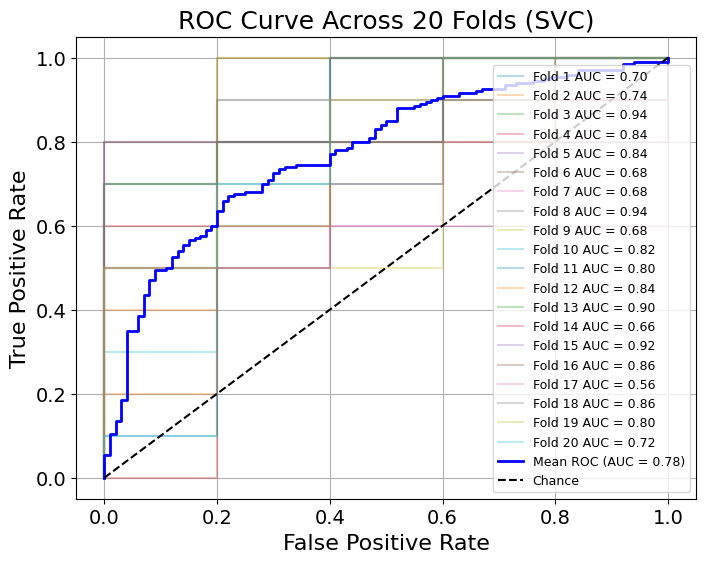

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

# Average ROC Curve
fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve Across 20 Folds (SVC)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)